In [1]:
import time
import bz2
import json
import pickle
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN, Birch, AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = '/sciclone/data10/twford/reddit/reddit/comments/'
BASE_PATH = '/sciclone/geograd/stmorse/reddit/'

# Examine cluster content

In [5]:
sample_sentences, sample_embeddings = utils.sample_cluster_sentences_and_embeddings(
    0, 
    0.01,
    years=[2007],
    months=['01'],
    seed=123
)

Loading ... 
> 2007-01: cluster size 4119, sampling ... (0.13)
> Sampled (s: 41) (e: (41, 384)) (3.11)
COMPLETE: 41, (41, 384)


In [6]:
cluster_centers = utils.load_cc('mbkm_cc_20_2007_2011')
cluster_centers.shape

(20, 384)

In [7]:
closest_points = utils.get_closest_vectors(cluster_centers[0], sample_embeddings, top_k=10)
closest_sentences = [sample_sentences[i] for i in closest_points]

print('\n'.join(closest_sentences))

If the baseline was everyone in our society having good healthcare, people would have to justify being jackasses and accumulating wealth by swindling or oppressing others by other means than "I want to be able to afford cancer treatment for my kids", etc.
That's an interesting link, thanks!

From a [related post](http://angrybear.blogspot.com/2005/04/real-crisis.html):

&gt; But this is just a sample; there's virtually no metric in which the US health care system provides better care than those of other countries, other than in care for the very rich. The reality is that the average person in the US receives mediocre care that is extremely expensive.

But doesn't this beg the question of whether % of GDP is the right number to be looking at? The very rich in the US, IIRC, contribute a disproportionate amount to GDP, so shouldn't it stand to reason that they are responsible for a disproportionate share of health care costs? Bill Gates probably spends more than $5,000 a year for his heal

# Plot all clusters over a sample

In [9]:
cluster_centers = utils.load_cc('mbkm_cc_20_2007_2011')
num_clusters = cluster_centers.shape[0]
cluster_centers.shape

(20, 384)

In [10]:
sample_embeddings, sample_labels = utils.sample_embeddings_and_labels(
    0.01, 
    years=[2007],
    months=['01'],
    seed=123
)
sample_embeddings.shape

Loading ...
> 2007-01: Sampling 589 from 58954 ... (0.32)
Complete.  Labels: (589,), Embeds: (589, 384)


(589, 384)

In [11]:
tsne = TSNE(n_components=2,
            perplexity=50.0,  # similar to nearest neighbors, 5-50
            early_exaggeration=24.0)  # tight in original -> tight in embedded 
tsne_values = tsne.fit_transform(sample_embeddings)

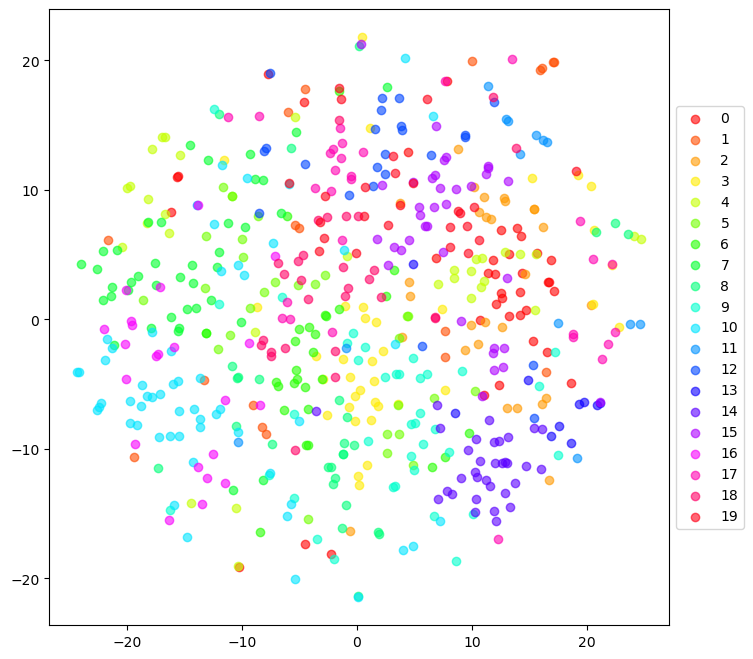

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# get colors for each cluster
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

for i in range(num_clusters):
    idx = np.where(sample_labels == i)[0]
    ax.scatter(tsne_values[idx, 0], 
               tsne_values[idx, 1], 
               c=[colors[i]], alpha=0.6, label=i)

# put the legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Sub-cluster

In [ ]:
# pick a cluster
# get embeddings
# re-cluster 

# repeat

# compare subclusters

## Cluster 1

In [7]:
# parameters for search
term = 'film'        # keyword for topic
top_k = 2                   # num clusters with this word dominant to grab
sel_clusters = []           # will hold cluster # corresponding to centroids
sel_counts = []             # will hold counts in that cluster (doc freq)
centroids = []              # will hold all centroids for these clusters
year_key = []               # keeps track of year corresponding to centroid
month = '03'                # for now just base the doc freq off one month

for year in [2009, 2010]:
    print(f'Processing {year} ...')

    # grab indices of this term in a given year
    with bz2.BZ2File(f'{DATA_PATH}RC_{year}-{month}.bz2', 'rb') as f:
        idx = []
        k = 0
        for line in f:
            entry = json.loads(line)
            if 'body' not in entry or entry['author'] == '[deleted]':
                continue
            
            if term in entry['body']:
                idx.append(k)

            k += 1

    idx = np.array(idx)
    print(idx.shape)

    # grab labels for this term
    labs = utils.load_npz(f'/sciclone/geograd/stmorse/reddit/', 
                          year, month, 'labels')

    # look at cluster (aka document) frequency
    cluster, count = np.unique(labs[idx], return_counts=True)
    top_c_idx = np.argsort(count)[::-1][:top_k]
    # print(f'All: {[(cl, co) for cl, co in zip(cluster, count)]}')
    print(f'Top: ', cluster[top_c_idx], count[top_c_idx])
    sel_clusters.append(cluster[top_c_idx])
    sel_counts.append(count[top_c_idx])

    # grab centroids corresponding to these top clusters
    cluster_centers = utils.load_cc(f'mbkm_cc_20_2007_2011', 
                                    base_path=f'{BASE_PATH}')
    for i in range(top_k):
        t = cluster[top_c_idx[i]]
        centroids.append(cluster_centers[t])
        year_key.append(year)

centroids = np.vstack(centroids)
sel_counts = np.vstack(sel_counts)
sel_clusters = np.vstack(sel_clusters)
print(centroids.shape)

Processing 2009 ...
(2763,)
Top:  [18  6] [1145  427]
Processing 2010 ...
(9637,)
Top:  [18  6] [4720 1376]
(4, 384)


In [37]:
# get embeddings for these two years in main cluster
embeddings_A, idx_A = utils.sample_cluster_embeddings(
    18, 0.01, years=[2009, 2010], months=['03']
)

Loading ...
> 2009-03: Sampling 557 from 55757 ... (3.90)
> Sampled (e: (557, 384)) (7.79)
> 2010-03: Sampling 2151 from 215136 ... (21.24)
> Sampled (e: (2151, 384)) (34.57)
COMPLETE: (2708, 384), (2708,)


In [56]:
# recluster
# cluster_model = HDBSCAN(
#     min_cluster_size=5,
#     leaf_size=40,
#     n_jobs=-1,
#     store_centers='centroid')

cluster_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=5,
    linkage='ward'
)

# idx = np.random.choice(embeddings_A.shape[0], size=10000)

cluster_model.fit(embeddings_A)

AgglomerativeClustering(distance_threshold=5, n_clusters=None)

In [58]:
cluster_model.n_clusters_

6

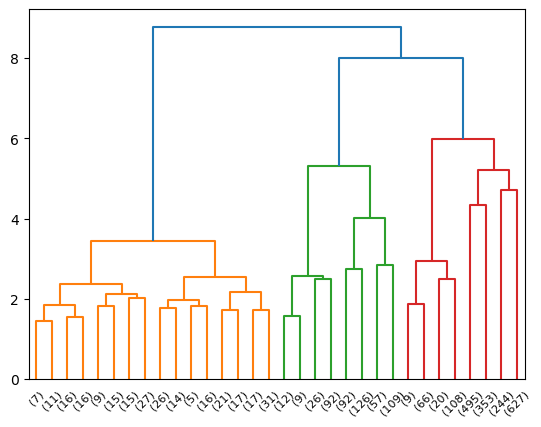

In [54]:
utils.plot_dendrogram(cluster_model, truncate_mode='level', p=4)

In [59]:
np.unique(cluster_model.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([871, 263, 848, 203, 139, 384]))

In [40]:
cluster_model.probabilities_[np.where(cluster_model.labels_ == 1)[0][:10]]

array([1.        , 1.        , 1.        , 1.        , 0.99920009,
       1.        ])

In [60]:
sample_sentences = []
with bz2.BZ2File(f'{DATA_PATH}RC_{2010}-{'03'}.bz2', 'rb') as f:
    k = 0
    for line in f:
        entry = json.loads(line)
        if 'body' not in entry or entry['author']=='[deleted]':
            continue

        if k in idx_A[557:]:
            sample_sentences.append(entry['body'])

        k += 1

len(sample_sentences)

2151

In [61]:
sample_sentences[:10]

['ANYTHING STEVE ALBINI HAS PRODUCED',
 "It's actually when he turns the wheel just slightly left and right; when the wheel gets closest to the pedal. We thought it was just his large toe cages, but even my clipless shoes would rub. \n\nIt makes such heavy contact with the wheel it can actually cause a quite dangerous unexpected slowdown :(",
 'The Xoan ambassador got drunk and wanted to use that dude as a rowboat, so they went out into the water and the Ambassador ended up drowning.\n\nYou can see the guard poking the dead body with a stick.',
 '[context](http://www.youtube.com/watch?v=xJyelcnINH0)',
 "Holy crap, you're right... that exact thought occurred to me.",
 'wait i dont get it...someone explain?',
 'I thought it was fantastic.  The huge floating moose? The human foozball game?  It was great!',
 'Fiest! Of course. I guess this just reminds me how much I hate the top 40 music.',
 'It was HARDLY talent.  Ricochet off a skate and someone just HAPPENED to be there.',
 'Check out [

In [64]:
[sample_sentences[i] for i in np.where(cluster_model.labels_[557:] == 2)[0][:10]]

["It's actually when he turns the wheel just slightly left and right; when the wheel gets closest to the pedal. We thought it was just his large toe cages, but even my clipless shoes would rub. \n\nIt makes such heavy contact with the wheel it can actually cause a quite dangerous unexpected slowdown :(",
 'I thought it was fantastic.  The huge floating moose? The human foozball game?  It was great!',
 'Fiest! Of course. I guess this just reminds me how much I hate the top 40 music.',
 'It was HARDLY talent.  Ricochet off a skate and someone just HAPPENED to be there.',
 'Terrible, terrible choices. People at the ceremonies were just as confused as we were.',
 'It would have been worth it.',
 'Somehow that flew right over some peoples heads...',
 'That is really funny.  Sounds like it was not such a bad weekend either besides that part in the airport. ',
 'I almost forgot.\n\nThe worst cactusification I can recall was a drunk golfer who made the Phoenix TV news when he got stuck with on

# Sub-cluster with tfidf

In [ ]:
# get sample of central sentences across a few months from all labels
# do tf-idf, pick a candidate cluster to sub-cluster
# sub-cluster

In [6]:
year = 2011
month = '03'

# load cluster centers
model_cc = utils.load_cc('mbkm_40_2011_td2_cc', base_path=BASE_PATH + 'td2/')
num_clusters = model_cc.shape[0]

# load labels
print('Load labels...')
labels = utils.load_npz(BASE_PATH + 'td2/', year, month, 'labels')

# load embeddings
print('Load embeddings...')
embeddings = utils.load_npz(BASE_PATH, year, month, 'embeddings')

# get index of closest to centroid
print('Computing centroid embeddings...')
top_k = 100
closest_idx = np.zeros((num_clusters, top_k))
for i in range(num_clusters):
    idx = np.where(labels==i)[0]
    closest_idx[i,:] = utils.get_closest_vectors_from_subset(
        model_cc[i], embeddings, idx, top_k=top_k)

# build corpus
# this will hold sentences vic centroid (row=cluster, entry=concat'd sentences)
print('Build corpus...')
corpus = ['' for _ in range(num_clusters)]
sentences = utils.load_sentences_bz2(DATA_PATH, year, month)
for i in range(num_clusters):
    # print(i, closest_idx[i,:3])
    corpus[i] += ' --- '.join([sentences[int(j)] for j in closest_idx[i,:]])


Load labels...
Load embeddings...
Computing centroid embeddings...
Build corpus...


In [7]:
# compute tf-idf
print('Compute tf-idf...')
vectorizer = TfidfVectorizer(
    input='content',
    max_df=0.3,
    # max_features=100,
    use_idf=True,
    smooth_idf=True
)

X = vectorizer.fit_transform(corpus)
print(X.shape)

Compute tf-idf...
(40, 11855)


In [9]:
for i in range(X.shape[0]):
    max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer.get_feature_names_out()[max_idx]
    # print(f'CLUSTER: {i}\n-----\n')
    # print(corpus[i][:100])
    # print(f'KEYWORD: {keyword}\n-----\n\n')
    print(f'{i}: {keyword}')

0: ['libertarian' 'libertarians' 'rights' 'government' 'political']
1: ['himself' 'character' 'interview' 'interviews' 'listen']
2: ['comic' 'movie' 'reference' 'homage' 'art']
3: ['programming' 'learning' 'tools' 'java' 'experience']
4: ['kitty' 'cat' 'fluffy' 'cute' 'baby']
5: ['text' 'writing' 'written' 'letter' 'winston']
6: ['article' 'headline' 'report' 'fox' 'npr']
7: ['racist' 'cultural' 'foreigners' 'culture' 'country']
8: ['delicious' 'tasty' 'eat' 'eating' 'syrup']
9: ['israel' 'jews' 'palestinians' 'israeli' 'israelis']
10: ['damage' 'range' 'opponent' 'hit' 'faster']
11: ['ಠ_ಠ' 'exploring' 'exposed' 'expose' 'exports']
12: ['jason' 'statham' 'mike' 'jimmy' 'jack']
13: ['police' 'cops' 'law' 'cop' 'crime']
14: ['hang' 'drunk' 'school' 'spring' 'beer']
15: ['music' 'song' 'movie' 'soundtrack' 'listening']
16: ['demand' 'supply' 'prices' 'scarcity' 'costs']
17: ['internet' 'karma' 'argument' 'insult' 'troll']
18: ['animal' 'animals' 'critters' 'spiders' 'creatures']
19: ['bus

In [10]:
cluster = 9
cluster_idx = np.where(labels==cluster)[0]
cluster_embeddings = embeddings[cluster_idx,:]
print(cluster_embeddings.shape)

ac = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=10,
    linkage='ward'
)

ac.fit(cluster_embeddings)

(18167, 384)


AgglomerativeClustering(distance_threshold=10, n_clusters=None)

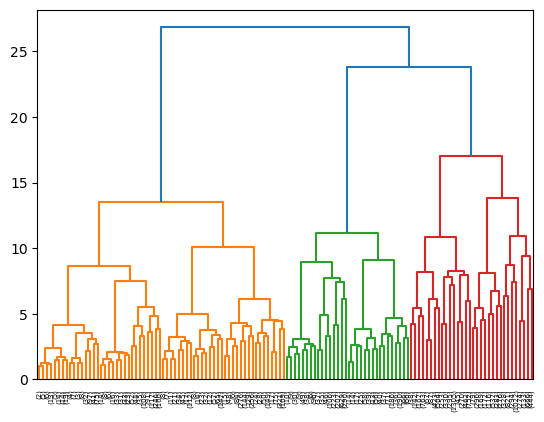

In [11]:
utils.plot_dendrogram(ac, truncate_mode='level', p=6)

In [12]:
ac2 = AgglomerativeClustering(
    n_clusters=25,
    # distance_threshold=10,
    linkage='ward'
)

ac2.fit(cluster_embeddings)

AgglomerativeClustering(n_clusters=25)

In [13]:
num_subclusters = 25

print('Build corpus...')
subcorpus = ['' for _ in range(num_subclusters)]
for i in range(num_subclusters):
    subcluster_idx = np.where(ac2.labels_==i)
    subcorpus[i] += ' --- '.join([
        sentences[int(j)] for j in cluster_idx[subcluster_idx]])

Build corpus...


In [14]:
# compute tf-idf
print('Compute tf-idf...')
vectorizer2 = TfidfVectorizer(
    input='content',
    max_df=0.3,
    # max_features=100,
    use_idf=True,
    smooth_idf=True
)

X2 = vectorizer2.fit_transform(subcorpus)
print(X2.shape)

Compute tf-idf...
(25, 28546)


In [15]:
for i in range(X2.shape[0]):
    max_idx = np.argsort(X2[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer2.get_feature_names_out()[max_idx]
    # print(f'CLUSTER: {i}\n-----\n')
    # print(subcorpus[i][:100])
    # print(f'KEYWORD: {keyword}\n-----\n\n')
    print(f'{i}: {keyword}')

0: ['residency' '1880' 'philistines' '1900s' 'transjordan']
1: ['mercenaries' 'swiss' 'harper' 'blah' 'ron']
2: ['oslo' 'freeze' 'accords' 'olmert' 'disengagement']
3: ['rafah' 'candy' 'aqsa' 'qassam' 'shells']
4: ['phosphorus' 'dome' 'illumination' 'incendiary' 'beale']
5: ['bulldozer' 'rapist' 'app' 'uganda' 'apple']
6: ['modernization' 'sustain' 'passport' 'conversion' 'blah']
7: ['qatari' 'bahraini' 'emir' 'monarchy' 'friedman']
8: ['eliezrie' 'unindicted' 'cair' 'linda' 'yorba']
9: ['stalin' 'gandhian' 'madagascar' 'genocides' 'gypsies']
10: ['armenian' 'armenians' 'kosovo' 'serbia' 'serbian']
11: ['wahhabi' 'ibn' 'salafis' 'salafi' 'hadith']
12: ['sectarian' 'ath' 'assad' 'ba' 'alawite']
13: ['copts' 'unrwa' 'fallacious' 'spam' '93_united_states_relations']
14: ['antisemites' 'adl' 'coined' 'ethos' 'antisemetism']
15: ['rajm' 'bankers' 'pork' 'oven' 'pizza']
16: ['d7' '25d7' 'unreal' 'passport' 'bla']
17: ['zaytoun' 'davis' 'beit' 'fayez' 'protocol']
18: ['matrix' 'machines' 'haz

In [28]:
subcluster_idx = np.where(ac2.labels_==6)[0]
subcluster_embeddings = cluster_embeddings[subcluster_idx]
print(subcluster_embeddings.shape)

ac3 = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=10,
    linkage='ward'
)

ac3.fit(subcluster_embeddings)

(853, 384)


AgglomerativeClustering(distance_threshold=10, n_clusters=None)

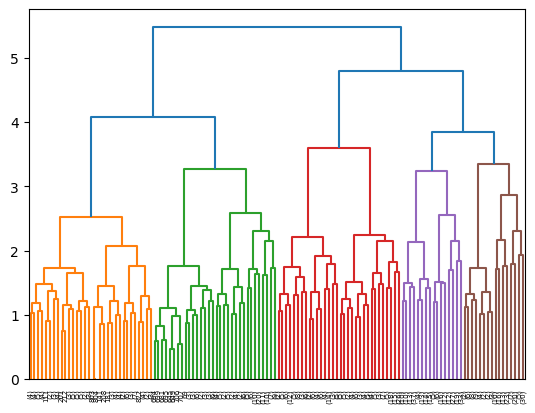

In [29]:
utils.plot_dendrogram(ac3, truncate_mode='level', p=6)

In [26]:
num_subclusters = 15

print('Build corpus...')
subcorpus = ['' for _ in range(num_subclusters)]
for i in range(num_subclusters):
    subsubcluster_idx = np.where(ac3.labels_==i)
    subcorpus[i] += ' --- '.join([
        sentences[int(j)] for j in cluster_idx[subcluster_idx[subsubcluster_idx]]])

# compute tf-idf
print('Compute tf-idf...')
vectorizer3 = TfidfVectorizer(
    input='content',
    max_df=0.8,
    # max_features=100,
    use_idf=True,
    smooth_idf=True
)

X3 = vectorizer3.fit_transform(subcorpus)
print(X3.shape)

for i in range(X3.shape[0]):
    max_idx = np.argsort(X3[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer3.get_feature_names_out()[max_idx]
    # print(f'\n\nCLUSTER: {i}\n-----')
    # print(f'KEYWORD: {keyword}\n-----\n')
    # print('\n'.join([s for s in subcorpus[i][:500].split('---')]))
    
    print(f'{i}: {keyword}')

Build corpus...
Compute tf-idf...
(15, 7122)
0: ['racism' 'racist' 'arab' 'palestinians' 'your']
1: ['american' 'help' 'our' 'everybody' 'your']
2: ['racist' 'your' 'racism' 'white' 'word']
3: ['your' 'palestinians' 'muslim' 'www' 'muslims']
4: ['orthodox' 'laws' 'reform' 'conversion' 'altoona']
5: ['arab' 'modernity' 'stability' 'modernization' 'perspective']
6: ['france' 'french' 'nationalism' 'your' 'europe']
7: ['he' 'laws' 'prohibition' 'homeland' 'home']
8: ['your' 'palestinians' 'our' 'hate' 'extremism']
9: ['palestinians' 'genetic' 'ancestors' 'arab' 'genetically']
10: ['reform' 'jew' 'conservative' 'orthodox' 'becoming']
11: ['haters' 'january' '1938' 'v3arui' '9xrzge']
12: ['nationality' 'jew' 'middle' 'gene' 'convert']
13: ['rule' 'your' 'live' 'usa' 'homeland']
14: ['done' 'zionists' 'intends' 'arabism' 'veto']


# Dimensionality reduction

In [52]:
# load embeddings
# try PCA
# check explained variance

In [53]:
embeddings, labels = utils.sample_embeddings_and_labels(
    sample_rate=0.1,
    years=[2007],
    months=['03']
)

Loading ...
> 2007-03: Sampling 7963 from 79638 ... (0.43)
Complete.  Labels: (7963,), Embeds: (7963, 384)


In [54]:
pca = PCA(n_components=embeddings.shape[1])
embed_components = pca.fit_transform(embeddings)

In [55]:
np.sum(pca.explained_variance_ratio_)

1.0

161 0.80161284050845


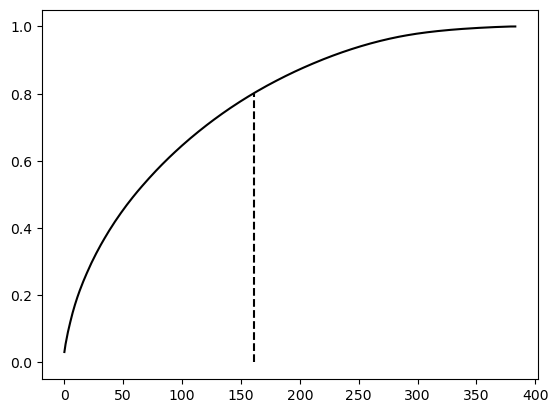

In [56]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
pct80 = np.where(cum_evr >= .80)[0][0]
print(pct80, cum_evr[pct80])

plt.plot(range(len(cum_evr)), cum_evr, 'k-')
plt.plot([pct80, pct80], [0, 0.8], 'k--')

# Hierarchical clustering

In [51]:
year = 2007
month = '03'

embeddings = utils.load_npz(BASE_PATH, year, month, 'embeddings')
embeddings.shape

(79638, 384)

In [57]:
pca = PCA(n_components=161)  # gets about 80% explained variance
embed_components = pca.fit_transform(embeddings)

In [62]:
ac = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=10,
    linkage='ward'
)

ac.fit(embed_components)

AgglomerativeClustering(distance_threshold=10, n_clusters=None)

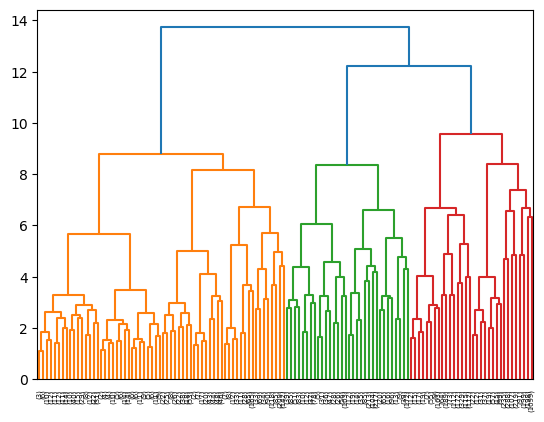

In [63]:
utils.plot_dendrogram(ac, truncate_mode='level', p=6)

In [64]:
ac = AgglomerativeClustering(
    n_clusters=12,
    linkage='ward'
)

ac.fit(embed_components)

AgglomerativeClustering(n_clusters=12)

In [65]:
sentences = utils.load_sentences_bz2(DATA_PATH, year, month)
len(sentences)

79638

In [66]:
corpus = []
sample_rate = 0.1

for k in np.unique(ac.labels_):
    idx = np.where(ac.labels_==k)[0]

    # create RNG with seed
    rng = np.random.default_rng()

    # sample_idx is indices to idx (sorted)
    sample_idx = rng.choice(len(idx), size=int(sample_rate * len(idx)), replace=False)
    sample_idx = np.sort(sample_idx)

    corpus.append(
        ' --- '.join([sentences[i] for i in idx[sample_idx]])
    )

len(corpus)

12

In [67]:
vectorizer = TfidfVectorizer(
    input='content',
    max_df=0.3,
    max_features=100,
    use_idf=True,
    smooth_idf=True
)

X = vectorizer.fit_transform(corpus)
X.shape

(12, 100)

In [70]:
for i in range(X.shape[0]):
    max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer.get_feature_names_out()[max_idx]
    print(corpus[i][:100])
    print(f'KEYWORD: {keyword}\n')

&gt;"We've also found chimpanzees articulating, on a genetic basis, new and **advanced capacities fo
KEYWORD: ['ais' 'female' 'magenta' 'spoon' 'israel']

More proof that pro atheletes are pussies. --- I wish someone could teach me some of these things.  
KEYWORD: ['sense' 'administration' 'vista' 'living' 'intelligence']

And to think that this Linus guy made an OS for far less than this. --- &gt;So, in addition to being
KEYWORD: ['hardaway' 'legally' 'scheme' 'broadcast' 'plt']

*Clerks* anyone? --- &gt; Both are 100% efficient at converting electrical energy to heat.

Nearly
KEYWORD: ['data' 'sense' 'atheists' 'mud' 'suffering']

You are absolutely wrong about the steel. Steel weakens under heat long before it melts. That's why 
KEYWORD: ['version' 'weeks' 'leader' 'female' 'imagine']

&gt;It is lack of agricultural infrastructure. That is the Govt's job.

Say, what? --- You'll find
KEYWORD: ['cough' 'lower' '20' 'leader' 'original']

&gt; Various Left-leaning organizations tend to 

# Topic dynamics 2 (tf-idf)

In [ ]:
# load cc for year
# load embeddings
# load sentences

# for each cluster:
# get closest points
# get sentences closest
# add to corpus

In [22]:
years = [2007, 2008]
month = '03'

corpi = {}

for year in years:
    print('Loading year ', year)

    # load cluster centers
    model_cc = utils.load_cc(f'mbkm_20_{year}_td_cc', base_path=BASE_PATH+'td/')
    num_clusters = model_cc.shape[0]

    # load embeddings
    print('Load embeddings...')
    embeddings = utils.load_npz(BASE_PATH, year, month, 'embeddings')

    # get index of closest to centroid
    top_k = 100
    closest_idx = np.zeros((num_clusters, top_k))
    for i in range(num_clusters):
        closest_idx[i,:] = utils.get_closest_vectors(
            model_cc[i], embeddings, top_k=top_k)

    # build corpus
    # this will hold sentences vic centroid (row=cluster, entry=concat'd sentences)
    print('Build corpus...')
    corpus = ['' for _ in range(num_clusters)]
    sentences = utils.load_sentences_bz2(DATA_PATH, year, month)
    for i in range(num_clusters):
        corpus[i] += ' --- '.join([sentences[int(j)] for j in closest_idx[i,:]])

    print('Computing tf-idf')
    vectorizer = TfidfVectorizer(
        input='content',
        max_df=0.3,
        # max_features=100,
        use_idf=True,
        smooth_idf=True
    )

    X = vectorizer.fit_transform(corpus)
    
    keywords = []
    for i in range(num_clusters):
        max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
        keyword = vectorizer.get_feature_names_out()[max_idx]
        keywords.append(keyword)

    corpi[year] = {
        i: {
            'corpus': corpus[i],
            'keywords': keywords[i]
        } for i in range(num_clusters)
    }


Loading year  2007
Load embeddings...
Build corpus...
Computing tf-idf
Loading year  2008
Load embeddings...
Build corpus...
Computing tf-idf


In [24]:
for year in years:
    print(f'{year}:\n-----\n')
    for i in range(len(corpi[year])):
        print(f'{i}: ', '_'.join([k for k in corpi[year][i]['keywords']]))

2007:
-----

0:  republican_ron_rove_paul_president
1:  writing_title_edu_greatergood_upenn
2:  ads_advertisement_viral_logo_saw
3:  health_drug_medical_alcohol_effects
4:  constitution_amendment_congress_patriot_citizens
5:  police_cops_she_officer_camera
6:  energy_economy_cost_oil_jobs
7:  riaa_customers_music_sales_itunes
8:  humor_insulting_joke_laugh_insults
9:  iran_iraq_invasion_civilians_israel
10:  java_languages_python_ruby_lisp
11:  gotta_afford_cash_backyard_wallet
12:  cute_picture_hahaha_jpg_dog
13:  christianity_religious_jesus_christian_christians
14:  evolution_atheists_atheism_scientific_religious
15:  women_sentence_female_facetious_original
16:  countries_culture_children_individual_ideas
17:  programming_code_firefox_addons_https
18:  karma_digg_sites_users_spam
19:  hello_hola_hehe_haha_aaaa
2008:
-----

0:  cops_cop_police_car_arrested
1:  woah_whee_haaa_hehe_eh
2:  night_buildings_picture_shuttle_near
3:  her_women_herself_female_girl
4:  book_watching_position

# Topic dynamics

### Using tf-idf approach

In [6]:
# parameters for search
term = 'war'        # keyword for topic
top_k = 2                   # num clusters with this word dominant to grab
sel_clusters = []           # will hold cluster # corresponding to centroids
sel_counts = []             # will hold counts in that cluster (doc freq)
centroids = []              # will hold all centroids for these clusters
year_key = []               # keeps track of year corresponding to centroid
month = '03'                # for now just base the doc freq off one month

for year in [2007, 2008, 2009, 2010, 2011]:
    print(f'Processing {year} ...')

    # grab indices of this term in a given year
    with bz2.BZ2File(f'{DATA_PATH}RC_{year}-{month}.bz2', 'rb') as f:
        idx = []
        k = 0
        for line in f:
            entry = json.loads(line)
            if 'body' not in entry or entry['author'] == '[deleted]':
                continue
            
            if term in entry['body']:
                idx.append(k)

            k += 1

    idx = np.array(idx)
    print(idx.shape)

    # grab labels for this term
    labs = utils.load_npz(f'/sciclone/geograd/stmorse/reddit/td/', 
                          year, month, 'labels')

    # look at cluster (aka document) frequency
    cluster, count = np.unique(labs[idx], return_counts=True)
    top_c_idx = np.argsort(count)[::-1][:top_k]
    print(f'All: {[(cl, co) for cl, co in zip(cluster, count)]}')
    print(f'Top: ', cluster[top_c_idx], count[top_c_idx])
    sel_clusters.append(cluster[top_c_idx])
    sel_counts.append(count[top_c_idx])

    # grab centroids corresponding to these top clusters
    cluster_centers = utils.load_cc(f'mbkm_20_{year}_td_cc', 
                                    base_path=f'{BASE_PATH}td/')
    for i in range(top_k):
        t = cluster[top_c_idx[i]]
        centroids.append(cluster_centers[t])
        year_key.append(year)

centroids = np.vstack(centroids)
sel_counts = np.vstack(sel_counts)
sel_clusters = np.vstack(sel_clusters)
print(centroids.shape)

Processing 2007 ...
(5215,)
All: [(0, 429), (1, 173), (2, 107), (3, 174), (4, 213), (5, 170), (6, 314), (7, 345), (8, 103), (9, 1016), (10, 757), (11, 116), (12, 97), (13, 135), (14, 269), (15, 105), (16, 201), (17, 327), (18, 132), (19, 32)]
Top:  [ 9 10] [1016  757]
Processing 2008 ...
(15682,)
All: [(0, 525), (1, 84), (2, 451), (3, 379), (4, 477), (5, 333), (6, 929), (7, 900), (8, 457), (9, 575), (10, 1293), (11, 689), (12, 793), (13, 1104), (14, 1039), (15, 301), (16, 222), (17, 2412), (18, 334), (19, 2385)]
Top:  [17 19] [2412 2385]
Processing 2009 ...
(32516,)
All: [(0, 5033), (1, 717), (2, 907), (3, 1067), (4, 1524), (5, 1078), (6, 1197), (7, 1087), (8, 2142), (9, 1080), (10, 2368), (11, 1087), (12, 960), (13, 3096), (14, 2482), (15, 1600), (16, 1313), (17, 1452), (18, 2052), (19, 274)]
Top:  [ 0 13] [5033 3096]
Processing 2010 ...
(97900,)
All: [(0, 1919), (1, 13337), (2, 8798), (3, 4457), (4, 3237), (5, 3675), (6, 3683), (7, 5951), (8, 10661), (9, 1564), (10, 1898), (11, 991),

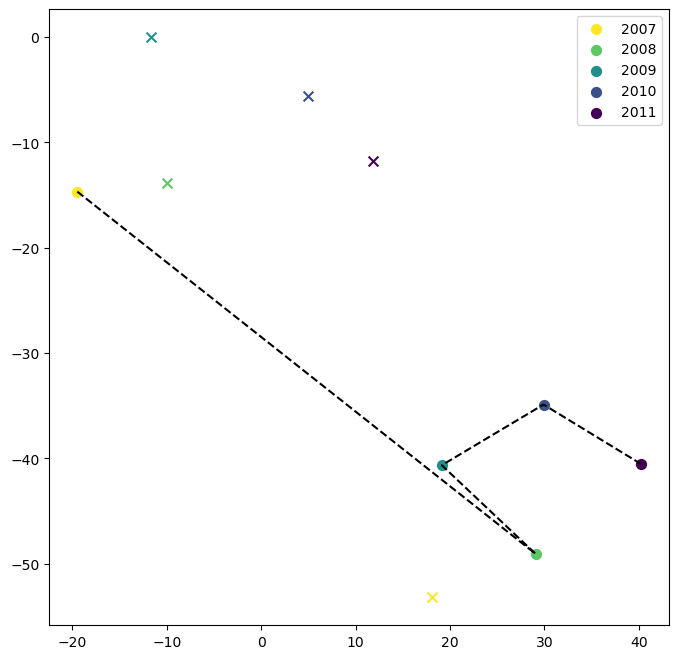

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ld = TSNE(n_components=2, perplexity=5, early_exaggeration=12)
# ld = PCA(n_components=2)
centroids_2d = ld.fit_transform(centroids)

# plot line between main centroids
ax.plot(centroids_2d[::2, 0], centroids_2d[::2, 1], 'k--')

years = [2007, 2008, 2009, 2010, 2011]
# colors = plt.cm.hsv(np.linspace(0, 1, len(years)))
colors = plt.get_cmap('viridis_r')(np.linspace(0, 1, len(years)))

for i, color in enumerate(colors):
    k = i*2

    # main centroid
    ax.scatter(centroids_2d[k:k+1,0], centroids_2d[k:k+1,1], 
               s=50, color=color, marker='o', label=years[i])
    
    # secondary centroid
    ax.scatter(centroids_2d[k+1:k+2,0], centroids_2d[k+1:k+2,1], 
               s=50, color=color, marker='x')

ax.legend()   
plt.show()

In [9]:
sample_embeddings = [] 
sample_rates = [0.1, 0.001]

for i, (j, year) in enumerate(zip([0, 4], [2007, 2011])):
    coi = sel_clusters[j][0]
    embeddings, _ = utils.sample_cluster_embeddings(
        coi, sample_rates[i], years=[year], months=[month],
        label_path='/sciclone/geograd/stmorse/reddit/td/')
    print(year, embeddings.shape)
    sample_embeddings.append(embeddings)

Loading ...
> 2007-03: Sampling 419 from 4199 ... (0.43)
> Sampled (e: (419, 384)) (0.87)
COMPLETE: (419, 384), (419,)
2007 (419, 384)
Loading ...
> 2011-03: Sampling 346 from 346386 ... (32.41)
> Sampled (e: (346, 384)) (64.70)
COMPLETE: (346, 384), (346,)
2011 (346, 384)


In [10]:
sample_embeddings = np.vstack(sample_embeddings)
print(sample_embeddings.shape)

# get equal amounts from each year
sample_embeddings2 = np.vstack((
    sample_embeddings[:200,:],
    sample_embeddings[419:619,:]
))
print(sample_embeddings2.shape)

(765, 384)
(400, 384)


(405, 384)


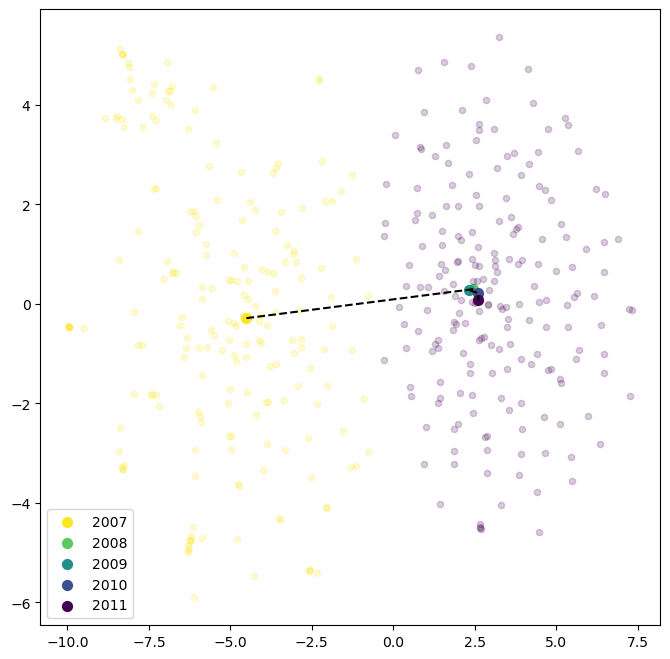

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

temp_array = np.vstack((
    sample_embeddings2,
    # centroids[[1, 3, 4, 6, 8],:]
    centroids[::2,:]
))

print(temp_array.shape)

ld = TSNE(n_components=2, perplexity=15, early_exaggeration=4)

# PCA keeps crashing the kernel, not sure why
# ld = PCA(n_components=2)

temp_2d = ld.fit_transform(temp_array)
embeds_2d = temp_2d[:400,:]
centroids_2d = temp_2d[400:]

# plot line between main centroids
ax.plot(centroids_2d[:, 0], centroids_2d[:, 1], 'k--')

years = [2007, 2008, 2009, 2010, 2011]
# # colors = plt.cm.hsv(np.linspace(0, 1, len(years)))
colors = plt.get_cmap('viridis_r')(np.linspace(0, 1, len(years)))

for i, color in enumerate(colors):

    # main centroid
    ax.scatter(centroids_2d[i,0], centroids_2d[i,1], 
               s=50, color=color, marker='o', label=years[i])
    
    if i==0:
        ax.scatter(embeds_2d[:200,0], embeds_2d[:200,1], s=20, color=color, alpha=0.2)
    elif i==4:
        ax.scatter(embeds_2d[200:,0], embeds_2d[200:,1], s=20, color=color, alpha=0.2)

ax.legend()
plt.show()

In [12]:
centroids.shape

(10, 384)

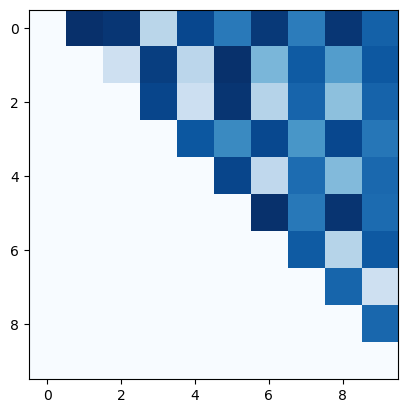

In [18]:
a = 0
b = 2

z = np.zeros((10,10))
for i in range(10):
    for j in range(i+1,10):
        z[i,j] = np.linalg.norm(centroids[i] - centroids[j])
        # print(f'{i} - {j} -- {np.linalg.norm(centroids[i] - centroids[j]):.3f}')

plt.imshow(z, cmap='Blues')

### Manual by-cluster

In [67]:
coi = 1                # cluster of interest
sample_rate = 0.01      # sample rate

sample_sentences, sample_embeddings = utils.sample_cluster_sentences_and_embeddings(
    coi, 
    sample_rate,
    years=[year],
    # months=[f'{m:02}' for m in range(1,13)],
    months=['03'],
    label_path='/sciclone/geograd/stmorse/reddit/td/',
    seed=123
)

Loading ... 
> 2010-03: cluster size 159196, sampling ... (2.71)
> Sampled (s: 1591) (e: (1591, 384)) (115.02)
COMPLETE: 1591, (1591, 384)


In [68]:
closest_points = utils.get_closest_vectors(cluster_centers[0], sample_embeddings, top_k=10)
closest_sentences = [sample_sentences[i] for i in closest_points]

print('\n'.join([s[:150] for s in closest_sentences]))

Oblivion.
Fallout Tactics.
Adeptus Mechanicus army! 

I will ease the machine's pain!
Masterba... wait no. Well, maybe. Eh try it.
[Source code](http://wonderfl.net/code/d0dcc2f2d0f8012e42785ef71dab7da2abd5453d) (and at 100% zoom so the pixels look "normal")

EDIT: HOLY CRAP. This
Big Mac.
thumbandthumber

I just wanted a new console themed name.  
Speed dial.
(With all DLC)
welcome to a battlefield game.


# User participation

# TF-IDF tests

- Idea: use TF-IDF within cluster to get top terms.  Cluster = document.  See BERTopic c-TF-IDF
- `tf(t, d)` is frequency of term `t` in document `d`
- `idf(t)` is total documents divided by number of documents `t` is in (higher when `t` is rarer, between 1 and 0).  Actually with smooth_idf=True, it does log( (1+n)/(1+df(t)) ) + 1  (as if extra document was seen containing every term in the collection exactly once)

In [4]:
year = 2007
month = '03'

labels = utils.load_npz(BASE_PATH, year, month, 'labels')

sentences = []
with bz2.BZ2File(f'{DATA_PATH}RC_{year}-{month}.bz2', 'rb') as f:
    for line in f:
        entry = json.loads(line)
        if 'body' not in entry or entry['author']=='[deleted]':
            continue

        sentences.append(entry['body'])

print(labels.shape, len(sentences))

(79638,) 79638


In [5]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([4146, 2892, 4600, 5416, 2895, 4536, 3548, 4224, 3440, 5882, 7424,
        2794, 3583, 1765, 3162, 5918, 2993, 2794, 3944, 3682]))

In [6]:
# each line k of corpus will be a sample of comments from that cluster
corpus = []
sample_rate = 0.01

for k in np.unique(labels):
    idx = np.where(labels==k)[0]

    # create RNG with seed
    rng = np.random.default_rng()

    # sample_idx is indices to idx (sorted)
    sample_idx = rng.choice(len(idx), size=int(sample_rate * len(idx)), replace=False)
    sample_idx = np.sort(sample_idx)

    corpus.append(
        ' --- '.join([sentences[i] for i in idx[sample_idx]])
    )

len(corpus)

20

In [7]:
corpus[0][:100]

'Well yes, but since national economics on a global scale are overseen if not directly managed by pol'

In [34]:
vectorizer = TfidfVectorizer(
    input='content',
    max_df=0.3,
    max_features=100,
    use_idf=True,
    smooth_idf=True
)

# X = vectorizer.fit_transform(sentences[:100])
X = vectorizer.fit_transform(corpus)
X.shape

(20, 100)

In [69]:
for i in range(X.shape[0]):
    max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer.get_feature_names_out()[max_idx]
    print(corpus[i][:100])
    print(f'KEYWORD: {keyword}\n')

&gt;"We've also found chimpanzees articulating, on a genetic basis, new and **advanced capacities fo
KEYWORD: ['ais' 'female' 'magenta' 'spoon' 'israel']

More proof that pro atheletes are pussies. --- I wish someone could teach me some of these things.  
KEYWORD: ['sense' 'administration' 'vista' 'living' 'intelligence']

And to think that this Linus guy made an OS for far less than this. --- &gt;So, in addition to being
KEYWORD: ['hardaway' 'legally' 'scheme' 'broadcast' 'plt']

*Clerks* anyone? --- &gt; Both are 100% efficient at converting electrical energy to heat.

Nearly
KEYWORD: ['data' 'sense' 'atheists' 'mud' 'suffering']

You are absolutely wrong about the steel. Steel weakens under heat long before it melts. That's why 
KEYWORD: ['version' 'weeks' 'leader' 'female' 'imagine']

&gt;It is lack of agricultural infrastructure. That is the Govt's job.

Say, what? --- You'll find
KEYWORD: ['cough' 'lower' '20' 'leader' 'original']

&gt; Various Left-leaning organizations tend to 

In [33]:
len(corpus[0])

21252

### older sandboxing

In [21]:
year = 2007
month = '03'

sentences = []
with bz2.BZ2File(f'{DATA_PATH}RC_{year}-{month}.bz2', 'rb') as f:
    for line in f:
        entry = json.loads(line)
        if 'body' not in entry or entry['author']=='[deleted]':
            continue

        sentences.append(entry['body'])

len(sentences)

79638

In [ ]:
counter = CountVectorizer(
    input='content',
    stop_words='english',
    max_df=0.7
)

# X = counter.fit_transform(sentences[:100])

In [28]:
counter.get_feature_names_out()

array(['000', '10', '100', ..., 'zimbabwe', 'zone', 'zulu'], dtype=object)

In [29]:
X.shape

(100, 1292)

In [30]:
transformer = TfidfTransformer()
transformer.fit(X)
transformer.idf_.shape

(1292,)

In [43]:
corpus = [
    'israel and hamas. --- Israel goes to war we\'re protesting --- another thought',
    'i love video games --- Did you see the DLC on steam is released --- Nintendo video games!',
    'his latest film is total crap --- Leonardo DiCaprio was amazing --- whos the director'
]

In [44]:
vectorizer = TfidfVectorizer(
    input='content',
    # max_df=0.7,
    # max_features=100,
    use_idf=True,
    smooth_idf=True
)

# X = vectorizer.fit_transform(sentences[:100])
X = vectorizer.fit_transform(corpus)
X.shape

(3, 35)

In [45]:
m = np.argmax(X[1,:])
X[1,m]

0.46936462408123697

In [41]:
np.amax(X[1,:])

0.0

In [46]:
for i in range(3):
    max_idx = np.argmax(X[i,:])
    keyword = vectorizer.get_feature_names_out()[max_idx]
    # print(sentences[i])
    print(corpus[i])
    print(f'KEYWORD: {keyword}\n')

israel and hamas. --- Israel goes to war we're protesting --- another thought
KEYWORD: israel

i love video games --- Did you see the DLC on steam is released --- Nintendo video games!
KEYWORD: games

his latest film is total crap --- Leonardo DiCaprio was amazing --- whos the director
KEYWORD: amazing

